# I. Installing Libraries and Dependencies

In [1]:
!pip install requests --upgrade --quiet

# parse and read html
!pip install beautifulsoup4 --upgrade --quiet  

# Sentiment analyzer
!pip install -U textblob --upgrade --quiet

!pip install nltk --upgrade  --quiet 

# Basic aricle summarization
!pip install newspaper3k --upgrade --quiet

# Deep learning article summarization
!pip install transformers --upgrade --quiet

In [2]:
import nltk
# nltk downloads for the Project
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hrith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hrith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hrith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hrith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import requests
from urllib.request import urlopen,Request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import Word
from newspaper import Article
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import pipeline
import re 
import csv
import os

### Stopwords

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# II. Pipeline 1: Sentiment Analysis of Stock data from Finviz website

In the first part, we will extract stock data for `Google`, `Amazon`, `Tesla`, `Intel`, `Nvidia` using their respective ticker, from Finviz Website. We clean the data and perform sentiment analysis to predict which stocks would be better for investment.

1. `finviz_parser_data` : Parse the html data using BeautifulSoup module.
<br>

2. `correct_time_formatting` : Rectify bad date and time format acquired from Finviz website to standardized format.
<br>

3. `finviz_create_write_data` : Extracts article title and article text and save it as a csv file.

In [5]:
def finviz_parser_data(ticker):
    
    url = 'https://finviz.com/quote.ashx?t={}'.format(ticker)
    # sending request for getting the html code of the Url
    try:
        request = Request(url=url,headers={'user-agent':'my-app'})
        response = urlopen(request)

        #parsing the HTML with BeautifulSoup
        soup = BeautifulSoup(response,'html')
        return soup
    except Exception as e:
        print(e)
def correct_time_formatting(time_data):
    date = []
    time=[]
    for z in time_data:
        a = z.split(" ")
        if len(a) == 2:
            date.append(a[0])
            time.append(a[1])
        else:
            date.append("r")
            time.append(a[0])
    l=0
    r=1
    lister=[]
    #print(l,r)
    while r<len(date):
        if len(date[r]) ==9:
            lister.append(date[l:r])
            #print(l,r)
            l=r
            #print(l,r)
        elif r== len(date)-1:                      
                r=len(date)    
                #print(l,r)
                lister.append(date[l:r])
        r+=1
    n =0
    while n <len(lister):

        lister[n] =[lister[n][0] for x in lister[n] if x=='r' or x==lister[n][0] ]
        n+=1
    final_time= []
    y =0
    while y<len(lister):
        final_time+=lister[y]
        y+=1    
    count = 0
    time_correct =[]
    while count<len(final_time):
        time_correct.append((final_time[count]+" "+time[count]))
        count+=1
    return time_correct

def finviz_create_write_data(soup,file_name="MSFT"):   
    try:
        news_reporter_title = [row.text for row in soup.find_all(class_ ='news-link-right') if row is not None]
        #news_reporter_title
        news_reported = [row.text for row in soup.find_all(class_ ='news-link-left') if row is not None]
        #news_reported
        news_url = [row.find('a',href=True)["href"] for row in soup.find_all(class_ ='news-link-left') if row is not None]
        '''
        solution 2:
        atags = [row.find('a') for row in soup.find_all(class_ ='news-link-left') if row is not None]
        news_url = [link['href'] for link in atags]
        '''
        date_data = [row.text for row in soup.find_all('td', attrs ={"width":"130",'align':'right'}) if row is not None]
        time = correct_time_formatting(date_data)
    except Exception as e:
        print(e)
    data = { "Time":time,'News Reporter': news_reporter_title,"News Headline": news_reported, "URL": news_url }
    finviz_news_df = pd.DataFrame.from_dict(data)
    finviz_news_df.to_csv(file_name + '_finviz_stock.csv')
    print(file_name + "_finviz_stock.csv is created" )
    return finviz_news_df

This function extracts the article text and title and creates a dataframe of the extracted data

In [6]:
def finviz_view_pandas_dataframe(ticker):
    url = 'https://finviz.com/quote.ashx?t={}'.format(ticker)
    # sending request for getting the html code of the Url
    try:
        request = Request(url=url,headers={'user-agent':'my-app'})
        response = urlopen(request)
        soup = BeautifulSoup(response,'html')
        news_reporter_title = [row.text for row in soup.find_all(class_ ='news-link-right') if row is not None]
        news_reported = [row.text for row in soup.find_all(class_ ='news-link-left') if row is not None]
        news_url = [row.find('a',href=True)["href"] for row in soup.find_all(class_ ='news-link-left') if row is not None]
        date_data = [row.text for row in soup.find_all('td', attrs ={"width":"130",'align':'right'}) if row is not None]
        time = correct_time_formatting(date_data)
    except Exception as e:
        print(e)
    data = { "Time":time,'News Reporter': news_reporter_title,"News Headline": news_reported, "URL": news_url }
    finviz_news_df = pd.DataFrame.from_dict(data)
    return finviz_news_df

## 1. Let's start with `GOOGLE` stock data 

In [7]:
google_stock = finviz_view_pandas_dataframe('GOOGL')
google_stock

,Time,News Reporter,News Headline,URL
0,Jan-04-23 07:25PM,MarketWatch,"Microsoft will benefit from ChatGPT, OpenAI in...",https://finance.yahoo.com/m/b37f6baa-7365-372a...
1,Jan-04-23 05:04PM,MarketWatch,Short sellers score $300 billion in 2022; bets...,https://finance.yahoo.com/m/5828b738-d608-3c1e...
2,Jan-04-23 05:00PM,Bloomberg,"Samsung Launches Smart-Home Hub, Pushing Deepe...",https://finance.yahoo.com/news/samsung-launche...
3,Jan-04-23 04:34PM,Yahoo Finance,CES 2023: Everything were expecting from the y...,https://finance.yahoo.com/news/ces-2023-everyt...
4,Jan-04-23 12:47PM,MarketWatch,Google and Facebooks dominance in digital ads ...,https://finance.yahoo.com/m/6e0c5baf-9a83-355b...
...,...,...,...,...
95,Dec-28-22 09:14PM,Insider Monkey,12 Best Most Active Stocks to Buy Now,https://finance.yahoo.com/news/12-best-most-ac...
96,Dec-28-22 05:45PM,Zacks,Alphabet Inc. (GOOG) Dips More Than Broader Ma...,https://finance.yahoo.com/news/alphabet-inc-go...
97,Dec-28-22 05:45PM,Zacks,Alphabet (GOOGL) Dips More Than Broader Market...,https://finance.yahoo.com/news/alphabet-googl-...
98,Dec-28-22 01:07PM,Investor's Business Daily,Cybersecurity Stocks: Why Acquisitions Could P...,https://finance.yahoo.com/m/2ac87adf-a50c-3394...


### > We will convert the Time data to proper standardized format.

In [8]:
google_stock["Time_standard_format"]= pd.to_datetime(google_stock['Time'],infer_datetime_format=True)
google_stock

,Time,News Reporter,News Headline,URL,Time_standard_format
0,Jan-04-23 07:25PM,MarketWatch,"Microsoft will benefit from ChatGPT, OpenAI in...",https://finance.yahoo.com/m/b37f6baa-7365-372a...,2023-01-04 19:25:00
1,Jan-04-23 05:04PM,MarketWatch,Short sellers score $300 billion in 2022; bets...,https://finance.yahoo.com/m/5828b738-d608-3c1e...,2023-01-04 17:04:00
2,Jan-04-23 05:00PM,Bloomberg,"Samsung Launches Smart-Home Hub, Pushing Deepe...",https://finance.yahoo.com/news/samsung-launche...,2023-01-04 17:00:00
3,Jan-04-23 04:34PM,Yahoo Finance,CES 2023: Everything were expecting from the y...,https://finance.yahoo.com/news/ces-2023-everyt...,2023-01-04 16:34:00
4,Jan-04-23 12:47PM,MarketWatch,Google and Facebooks dominance in digital ads ...,https://finance.yahoo.com/m/6e0c5baf-9a83-355b...,2023-01-04 12:47:00
...,...,...,...,...,...
95,Dec-28-22 09:14PM,Insider Monkey,12 Best Most Active Stocks to Buy Now,https://finance.yahoo.com/news/12-best-most-ac...,2022-12-28 21:14:00
96,Dec-28-22 05:45PM,Zacks,Alphabet Inc. (GOOG) Dips More Than Broader Ma...,https://finance.yahoo.com/news/alphabet-inc-go...,2022-12-28 17:45:00
97,Dec-28-22 05:45PM,Zacks,Alphabet (GOOGL) Dips More Than Broader Market...,https://finance.yahoo.com/news/alphabet-googl-...,2022-12-28 17:45:00
98,Dec-28-22 01:07PM,Investor's Business Daily,Cybersecurity Stocks: Why Acquisitions Could P...,https://finance.yahoo.com/m/2ac87adf-a50c-3394...,2022-12-28 13:07:00


### > Cleaning the data of Stopwords

In [9]:
def clean_data(df,column_filter ='News Headline',other_column='Time_standard_format'):
    try:
        new_df = df.filter([column_filter,other_column])
        new_df['Lower_Case_Headline'] = new_df[column_filter].apply(lambda x: " ".join(word.lower() for word in x.split()))
        new_df['Punctuation_Removed'] = new_df['Lower_Case_Headline'].str.replace("[^\w\s]","",regex = True)
        new_df["StopWords_removed"] = new_df['Punctuation_Removed'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
        new_df['Lemmatized'] = new_df["StopWords_removed"].apply(lambda x: ' '.join(Word(word).lemmatize() for word in x.split()))
        return new_df
    except Exception as e:
        print(e)
# To find other unnecessary stop word -------->Optional function
def find_unnecessary_stop_words(df,count):
    try:
        series = pd.Series(''.join(df["Lemmatized"]).split()).value_counts()[:count]
        return series
    except Exception as e:
        print(e)
def cleaning_secondary(df,apply_column = "Lemmatized"):
    try:
        df['Cleaned Sentiment'] =df[apply_column].apply(lambda x: " ".join(word for word in x.split() if word not in other_stop_words ))
        return df
    except Exception as e:
        print(e)

In [10]:
cleaned_df = clean_data(google_stock,column_filter ='News Headline',other_column='Time_standard_format') #other_column is generally time field in df
cleaned_df

,News Headline,Time_standard_format,Lower_Case_Headline,Punctuation_Removed,StopWords_removed,Lemmatized
0,"Microsoft will benefit from ChatGPT, OpenAI in...",2023-01-04 19:25:00,"microsoft will benefit from chatgpt, openai in...",microsoft will benefit from chatgpt openai in ...,microsoft benefit chatgpt openai multiple ways...,microsoft benefit chatgpt openai multiple way ...
1,Short sellers score $300 billion in 2022; bets...,2023-01-04 17:04:00,short sellers score $300 billion in 2022; bets...,short sellers score 300 billion in 2022 bets a...,short sellers score 300 billion 2022 bets tesl...,short seller score 300 billion 2022 bet tesla ...
2,"Samsung Launches Smart-Home Hub, Pushing Deepe...",2023-01-04 17:00:00,"samsung launches smart-home hub, pushing deepe...",samsung launches smarthome hub pushing deeper ...,samsung launches smarthome hub pushing deeper ...,samsung launch smarthome hub pushing deeper am...
3,CES 2023: Everything were expecting from the y...,2023-01-04 16:34:00,ces 2023: everything were expecting from the y...,ces 2023 everything were expecting from the ye...,ces 2023 everything expecting years biggest te...,ce 2023 everything expecting year biggest tech...
4,Google and Facebooks dominance in digital ads ...,2023-01-04 12:47:00,google and facebooks dominance in digital ads ...,google and facebooks dominance in digital ads ...,google facebooks dominance digital ads challen...,google facebooks dominance digital ad challeng...
...,...,...,...,...,...,...
95,12 Best Most Active Stocks to Buy Now,2022-12-28 21:14:00,12 best most active stocks to buy now,12 best most active stocks to buy now,12 best active stocks buy,12 best active stock buy
96,Alphabet Inc. (GOOG) Dips More Than Broader Ma...,2022-12-28 17:45:00,alphabet inc. (goog) dips more than broader ma...,alphabet inc goog dips more than broader marke...,alphabet inc goog dips broader markets know,alphabet inc goog dip broader market know
97,Alphabet (GOOGL) Dips More Than Broader Market...,2022-12-28 17:45:00,alphabet (googl) dips more than broader market...,alphabet googl dips more than broader markets ...,alphabet googl dips broader markets know,alphabet googl dip broader market know
98,Cybersecurity Stocks: Why Acquisitions Could P...,2022-12-28 13:07:00,cybersecurity stocks: why acquisitions could p...,cybersecurity stocks why acquisitions could pi...,cybersecurity stocks acquisitions could pick 2023,cybersecurity stock acquisition could pick 2023


In [11]:
series = find_unnecessary_stop_words(cleaned_df,30)
series

stock        36
buy          17
google       13
googl        11
tech         10
alphabet      9
2023          8
antitrust     8
market        6
top           6
amazon        5
year          5
new           5
youtube       5
android       5
boost         4
growth        4
2022          4
india         4
dip           4
eu            4
investor      4
dominance     3
2             3
ad            3
watch         3
hold          3
big           3
could         3
tribunal      3
dtype: int64

In [12]:
other_stop_words = ['ev','pickup',"stock",'china']
cleaned_final = cleaning_secondary(cleaned_df)
cleaned_final

,News Headline,Time_standard_format,Lower_Case_Headline,Punctuation_Removed,StopWords_removed,Lemmatized,Cleaned Sentiment
0,"Microsoft will benefit from ChatGPT, OpenAI in...",2023-01-04 19:25:00,"microsoft will benefit from chatgpt, openai in...",microsoft will benefit from chatgpt openai in ...,microsoft benefit chatgpt openai multiple ways...,microsoft benefit chatgpt openai multiple way ...,microsoft benefit chatgpt openai multiple way ...
1,Short sellers score $300 billion in 2022; bets...,2023-01-04 17:04:00,short sellers score $300 billion in 2022; bets...,short sellers score 300 billion in 2022 bets a...,short sellers score 300 billion 2022 bets tesl...,short seller score 300 billion 2022 bet tesla ...,short seller score 300 billion 2022 bet tesla ...
2,"Samsung Launches Smart-Home Hub, Pushing Deepe...",2023-01-04 17:00:00,"samsung launches smart-home hub, pushing deepe...",samsung launches smarthome hub pushing deeper ...,samsung launches smarthome hub pushing deeper ...,samsung launch smarthome hub pushing deeper am...,samsung launch smarthome hub pushing deeper am...
3,CES 2023: Everything were expecting from the y...,2023-01-04 16:34:00,ces 2023: everything were expecting from the y...,ces 2023 everything were expecting from the ye...,ces 2023 everything expecting years biggest te...,ce 2023 everything expecting year biggest tech...,ce 2023 everything expecting year biggest tech...
4,Google and Facebooks dominance in digital ads ...,2023-01-04 12:47:00,google and facebooks dominance in digital ads ...,google and facebooks dominance in digital ads ...,google facebooks dominance digital ads challen...,google facebooks dominance digital ad challeng...,google facebooks dominance digital ad challeng...
...,...,...,...,...,...,...,...
95,12 Best Most Active Stocks to Buy Now,2022-12-28 21:14:00,12 best most active stocks to buy now,12 best most active stocks to buy now,12 best active stocks buy,12 best active stock buy,12 best active buy
96,Alphabet Inc. (GOOG) Dips More Than Broader Ma...,2022-12-28 17:45:00,alphabet inc. (goog) dips more than broader ma...,alphabet inc goog dips more than broader marke...,alphabet inc goog dips broader markets know,alphabet inc goog dip broader market know,alphabet inc goog dip broader market know
97,Alphabet (GOOGL) Dips More Than Broader Market...,2022-12-28 17:45:00,alphabet (googl) dips more than broader market...,alphabet googl dips more than broader markets ...,alphabet googl dips broader markets know,alphabet googl dip broader market know,alphabet googl dip broader market know
98,Cybersecurity Stocks: Why Acquisitions Could P...,2022-12-28 13:07:00,cybersecurity stocks: why acquisitions could p...,cybersecurity stocks why acquisitions could pi...,cybersecurity stocks acquisitions could pick 2023,cybersecurity stock acquisition could pick 2023,cybersecurity acquisition could pick 2023


### > Performing Sentiment Analysis

In [19]:
def sentiment_analyzer(df,column_applied_df = "final_sentiment_cleaned",other_column="Time_standard_format"):
    try:
        
        analyzer = SentimentIntensityAnalyzer()
        df['nltk_subjective'] = df[column_applied_df].apply(lambda x: analyzer.polarity_scores(x)['compound'])
        df['nltk_positive'] = df[column_applied_df].apply(lambda x: analyzer.polarity_scores(x)['pos'])
        df['nltk_neutral'] = df[column_applied_df].apply(lambda x: analyzer.polarity_scores(x)['neu'])
        df['nltk_negative'] = df[column_applied_df].apply(lambda x: analyzer.polarity_scores(x)['neg'])
        df['textblob_polarity'] = df[column_applied_df].apply(lambda x: TextBlob(x).sentiment[0])
        df['textblob_subjective'] = df[column_applied_df].apply(lambda x: TextBlob(x).sentiment[1])
        #'nltk_positive','nltk_neutral','nltk_negative',
        new_df = df.filter([other_column,'News Headline',column_applied_df,'nltk_subjective','textblob_polarity','textblob_subjective'])
        return new_df
    except Exception as e:
        print(e)

In [20]:
sentiment = sentiment_analyzer(cleaned_final,column_applied_df = "Cleaned Sentiment") #other_column is generally time field in df
sentiment

,Time_standard_format,News Headline,Cleaned Sentiment,nltk_subjective,textblob_polarity,textblob_subjective
0,2023-01-04 19:25:00,"Microsoft will benefit from ChatGPT, OpenAI in...",microsoft benefit chatgpt openai multiple way ...,0.4588,0.000000,0.50
1,2023-01-04 17:04:00,Short sellers score $300 billion in 2022; bets...,short seller score 300 billion 2022 bet tesla ...,0.1779,0.000000,0.30
2,2023-01-04 17:00:00,"Samsung Launches Smart-Home Hub, Pushing Deepe...",samsung launch smarthome hub pushing deeper am...,0.1779,0.000000,0.00
3,2023-01-04 16:34:00,CES 2023: Everything were expecting from the y...,ce 2023 everything expecting year biggest tech...,0.0000,0.000000,0.00
4,2023-01-04 12:47:00,Google and Facebooks dominance in digital ads ...,google facebooks dominance digital ad challeng...,0.2732,0.000000,0.00
...,...,...,...,...,...,...
95,2022-12-28 21:14:00,12 Best Most Active Stocks to Buy Now,12 best active buy,0.7845,0.433333,0.45
96,2022-12-28 17:45:00,Alphabet Inc. (GOOG) Dips More Than Broader Ma...,alphabet inc goog dip broader market know,0.0000,0.000000,0.00
97,2022-12-28 17:45:00,Alphabet (GOOGL) Dips More Than Broader Market...,alphabet googl dip broader market know,0.0000,0.000000,0.00
98,2022-12-28 13:07:00,Cybersecurity Stocks: Why Acquisitions Could P...,cybersecurity acquisition could pick 2023,0.0000,0.000000,0.00


In [21]:
sentiment_df= sentiment.sort_values(by=['nltk_subjective','textblob_polarity',"textblob_subjective"],ascending=[True,True,True],na_position='first')
sentiment_df

,Time_standard_format,News Headline,Cleaned Sentiment,nltk_subjective,textblob_polarity,textblob_subjective
67,2022-12-30 17:28:00,Tesla is not alone: 20 (and a half) other big ...,tesla alone 20 half big worst year record,-0.7269,-0.388889,0.422222
75,2022-12-29 19:59:00,Tesla is not alone: 18 (and a half) other big ...,tesla alone 18 half big headed worst year record,-0.7269,-0.388889,0.422222
9,2023-01-04 11:41:00,Alphabet's (GOOGL) Google Builds Terrorism Mod...,alphabet googl google build terrorism moderati...,-0.6808,0.000000,0.000000
33,2023-01-03 10:53:00,Google Helps Smaller Websites Fight Terrorism ...,google help smaller website fight terrorism li...,-0.6705,0.250000,0.700000
26,2023-01-03 18:30:00,RPT-Google alleges India antitrust body copied...,rptgoogle alleges india antitrust body copied ...,-0.6369,0.000000,0.000000
...,...,...,...,...,...,...
25,2023-01-03 22:35:00,Microsoft Hopes OpenAIs Chatbot Will Make Bing...,microsoft hope openais chatbot make bing smarter,0.7096,0.000000,0.000000
49,2023-01-03 05:10:00,2 Remarkable Growth Stocks Set to Soar in 2023...,2 remarkable growth set soar 2023 according wa...,0.7351,0.750000,0.750000
92,2022-12-29 05:06:00,2 Artificial Intelligence Stocks to Buy Hand O...,2 artificial intelligence buy hand fist 2023 1...,0.7650,-0.600000,1.000000
95,2022-12-28 21:14:00,12 Best Most Active Stocks to Buy Now,12 best active buy,0.7845,0.433333,0.450000


### > Visualizing

In [16]:
# Visualization function
def matplotlib_sentiment(dates,values):
    try:
        graph_data = plt.scatter(dates,values)
        return graph_data
    except Exception as e:
        print(e)

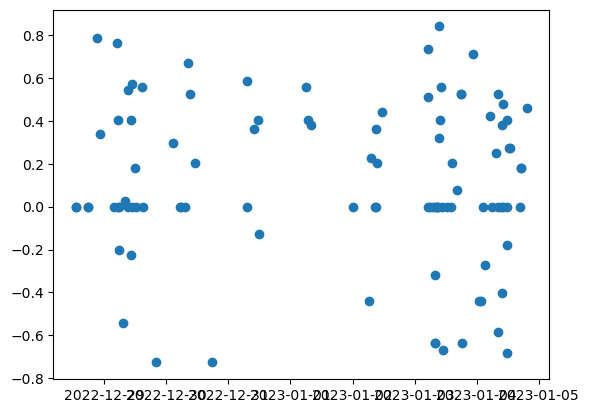

In [22]:
matplotlib_sentiment(sentiment_df['Time_standard_format'],sentiment_df["nltk_subjective"])

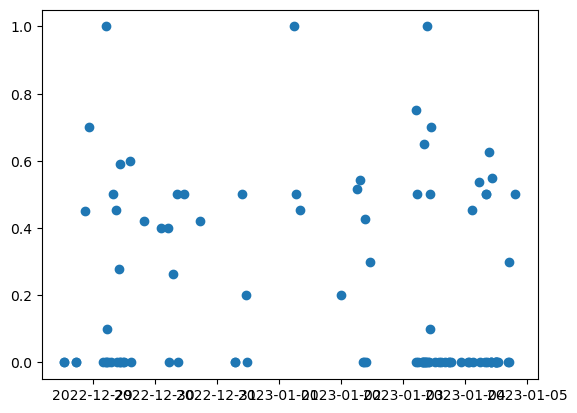

In [23]:
matplotlib_sentiment(sentiment_df['Time_standard_format'],sentiment_df["textblob_subjective"])

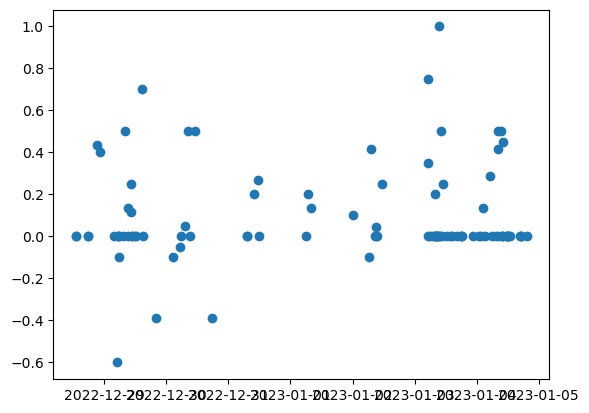

In [24]:
matplotlib_sentiment(sentiment_df['Time_standard_format'],sentiment_df["textblob_polarity"])

## 2. Sentiment Analysis on other Companies stock data

In [25]:
def create_csv_ticker_list(ticker_list):
    try:
        for ticker in ticker_list:
            soup = finviz_parser_data(ticker)
            finviz_create_write_data(soup,file_name=ticker)
    except Exception as e:
        print(e)

In [26]:
# TSLA is Tesla
# AMZN is Amazon
# INTC is Intel
# NVDA is Nvidia
ticker_list = ['TSLA', 'AMZN', 'INTC', 'NVDA']

In [27]:
create_csv_ticker_list(ticker_list)

TSLA_finviz_stock.csv is created
AMZN_finviz_stock.csv is created
INTC_finviz_stock.csv is created
NVDA_finviz_stock.csv is created


In [30]:
def sentiment_analyzer_from_file(file_name):
    try:
        df = pd.read_csv(file_name).drop(["Unnamed: 0"],axis = 1)
        clean_df = clean_data(df,column_filter ='News Headline')
        sentiment_df = sentiment_analyzer(clean_df,column_applied_df = "Lemmatized")
        return sentiment_df
    except Exception as e:
        print(e)

### > Tesla Stock

In [31]:
sentiment_analyzer_from_file('TSLA_finviz_stock.csv')

,News Headline,Lemmatized,nltk_subjective,textblob_polarity,textblob_subjective
0,"Dow Jones Futures Fall After Stocks Rise, Micr...",dow jones future fall stock rise microsoft tum...,0.0000,0.000000,0.125
1,Sony and Honda Unveil Afeela EV in Latest Chal...,sony honda unveil afeela ev latest challenge t...,0.0772,0.500000,0.900
2,Dow Jones Rises Despite Microsoft Sell-Off; Be...,dow jones rise despite microsoft selloff bewar...,0.0000,0.000000,0.000
3,"If you had invested $1,000 in Tesla 5 years ag...",invested 1000 tesla 5 year ago youd 4973 today...,0.5267,0.000000,0.000
4,A Horrifying Incident Shows Off Tesla Safety S...,horrifying incident show tesla safety standard,-0.2263,-0.450000,0.500
...,...,...,...,...,...
95,"SpaceX valued at $137 billion, GE health care ...",spacex valued 137 billion ge health care spino...,0.7845,0.416667,0.500
96,"Tesla stock tanks on delivery whiff, JPMorgan ...",tesla stock tank delivery whiff jpmorgan note,0.0000,0.000000,0.000
97,Tesla shares slide after deliveries fall short...,tesla share slide delivery fall short wall st ...,0.2960,0.000000,0.300
98,"Buying Bitcoin Now Is a Perfect Play, Wall Str...",buying bitcoin perfect play wall street powerh...,0.7269,1.000000,1.000


### > Amazon Stock

In [32]:
sentiment_analyzer_from_file('AMZN_finviz_stock.csv')

,News Headline,Lemmatized,nltk_subjective,textblob_polarity,textblob_subjective
0,"Amazon to Slash More Than 18,000 Jobs in Escal...",amazon slash 18000 job escalation cut,-0.3612,0.000000,0.00
1,"Amazon Layoffs to Hit Over 18,000 Workers, the...",amazon layoff hit 18000 worker recent tech wave,0.1779,0.000000,0.25
2,"Amazon plans to cut 18,000 jobs to rein in costs",amazon plan cut 18000 job rein cost,-0.1027,0.000000,0.00
3,"Amazon Will Lay Off 18,000 Employees, CEO Andy...",amazon lay 18000 employee ceo andy jassy say,0.1779,0.000000,0.00
4,How Amazon Could 'Steal' Season 2 of Netflix's...,amazon could steal season 2 netflixs hottest show,-0.3612,0.000000,0.00
...,...,...,...,...,...
95,Nasdaq Bear Market: 5 Extraordinary Growth Sto...,nasdaq bear market 5 extraordinary growth stoc...,-0.0516,0.333333,1.00
96,Could This Group of Workers Be Hit Hardest by ...,could group worker hit hardest recession,-0.4215,0.000000,0.00
97,Amazon (AMZN) Stock Moves -0.21%: What You Sho...,amazon amzn stock move 021 know,0.1779,0.000000,0.00
98,Have $500? These 2 Stocks Could Be Bargain Buy...,500 2 stock could bargain buy 2023 beyond,0.2023,0.000000,0.00


### > Intel Stock

In [33]:
sentiment_analyzer_from_file('INTC_finviz_stock.csv')

,News Headline,Lemmatized,nltk_subjective,textblob_polarity,textblob_subjective
0,Tech Companies Keep Slashing Jobs in Uncertain...,tech company keep slashing job uncertain 2023 ...,-0.5106,0.000000,0.000000
1,Intel to Report Fourth-Quarter and Full-Year 2...,intel report fourthquarter fullyear 2022 finan...,0.0000,0.000000,0.000000
2,"Why Intel, Qualcomm, and TSMC Stocks Popped Today",intel qualcomm tsmc stock popped today,0.0000,0.000000,0.000000
3,Here are the chip companies that should benefi...,chip company benefit government massive incentive,0.6705,0.000000,1.000000
4,What the Latest Updates Mean for Intel and Nvi...,latest update mean intel nvidia investor,0.0000,0.093750,0.793750
...,...,...,...,...,...
95,"Intel, Dutch Bros and jobs: The PBJ's top-read...",intel dutch bros job pbjs topread story 2022,0.0000,0.000000,0.000000
96,Could Intel's Pain Become This Dividend Stock'...,could intels pain become dividend stock gain,0.0258,0.000000,0.000000
97,Could Amazon's New Chip Be the End of AMD and ...,could amazon new chip end amd chip stock,0.1779,0.136364,0.454545
98,Intel Has a $39 Billion Graphics Opportunity,intel 39 billion graphic opportunity,0.4215,0.000000,0.400000


### > Nvidia Stock

In [34]:
sentiment_analyzer_from_file('NVDA_finviz_stock.csv')

,News Headline,Lemmatized,nltk_subjective,textblob_polarity,textblob_subjective
0,CES 2023: AMD seeks to attract Nvidias custome...,ce 2023 amd seek attract nvidias customer adva...,0.5423,0.268182,0.527273
1,Nvidia Analyst Hails Attractive Pricing Of Clo...,nvidia analyst hail attractive pricing cloud g...,0.4939,0.800000,1.000000
2,CES 2023: A new metaverse headset gets early b...,ce 2023 new metaverse headset get early buzz a...,0.0000,0.118182,0.377273
3,"NVIDIA (NVDA), Foxconn Team up for Autonomous ...",nvidia nvda foxconn team autonomous vehicle pl...,0.0000,0.400000,0.700000
4,What Nvidia announced at CES: Foxconn EV partn...,nvidia announced ce foxconn ev partnership clo...,0.0000,0.000000,0.400000
...,...,...,...,...,...
95,"Nvidia, AMD, and Other Chip Stocks Slip After ...",nvidia amd chip stock slip micron disappoints,-0.3818,0.000000,0.000000
96,2 Magnificent Semiconductor Stocks Down 46% an...,2 magnificent semiconductor stock 46 51 buy ne...,0.5994,0.500000,0.500000
97,Intel has spared a part of its chips business ...,intel spared part chip business chopping block,-0.4404,0.000000,0.000000
98,NVIDIA (NVDA) vs. Taiwan Semiconductor (TSM): ...,nvidia nvda v taiwan semiconductor tsm better ...,0.4404,0.500000,0.500000


## 3. Conlusion (Pipeline 1)

### Summarizing:
1. Passed a ticker value to the function to download our CSV file for the ticker.

2. Viewed the stock data of a selected ticker.

3. Cleaned using Stopwords.

4. Cleaned the News headline of the data.

5. Apply sentiment analysis on the cleaned News Headlines.

6. Analyzed the sentiment with basic scatter plot.

7. Declared a ticker list and used it to scrape multiple tickers and performed sentiment analysis on them.

# III. Pipeline 2: Sentiment Analysis of Stock Data with Google Stock News

## 1. Summarization Model (Financial Summarization Pegasus model)

A deep learning arsenal basically meant for NLP projects. The summarization models abstracts the given text to logical and concise summarization.

In [35]:
#model_setup
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [36]:
def pegasus_summarize(articles):
    try:
        summaries = []
        for article in articles:
            input_ids = tokenizer.encode(article, return_tensors='pt')
            output = model.generate(input_ids, max_length=55, num_beams=5, early_stopping=True)
            summary = tokenizer.decode(output[0], skip_special_tokens=True)
            summaries.append(summary)
    except Exception as e:
            summaries.append(e)
    return summaries

## 2. Extracting Data 

In [37]:
def google_search_stocknews(ticker,num=100,site="yahoo+finance"):
    try:
        search_url = "https://www.google.com/search?q={}+{}&tbm=nws&num={}".format(site,ticker,num)
        # url_analysis: https://www.google.com/search?q={query}&tbm=nws&num=100
        # &tbm=nws: google new Tab, &num={} example: 100 and will return the top 100 results, query:site +ticker
        r = requests.get(search_url)
        soup = BeautifulSoup(r.text, 'html.parser')
        atags = soup.find_all('a')
        hrefs = [link['href'] for link in atags]
        return hrefs 
    except Exception as e:
        print(e)

In [38]:
tickers_2 = ['TSLA', 'INTC', 'AMZN', 'NVDA', 'GOOGL']

## 3. Processing

### > Extracting all url's for each stocks

In [39]:
# storing the URLs in a dictionary
raw_urls_to_dictionary = {ticker:google_search_stocknews(ticker,5) for ticker in tickers_2}
raw_urls_to_dictionary

{'TSLA': ['/?sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQOwgC',
  '/search?q=yahoo+finance+TSLA&tbm=nws&num=5&ie=UTF-8&gbv=1&sei=zma2Y6fMApW95OUPn9Oo2Ao',
  '/search?q=yahoo+finance+TSLA&num=5&ie=UTF-8&source=lnms&sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQ_AUIBSgA',
  '/search?q=yahoo+finance+TSLA&num=5&ie=UTF-8&tbm=vid&source=lnms&sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQ_AUIBygC',
  '/search?q=yahoo+finance+TSLA&num=5&ie=UTF-8&tbm=isch&source=lnms&sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQ_AUICCgD',
  'https://maps.google.com/maps?q=yahoo+finance+TSLA&num=5&um=1&ie=UTF-8&sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQ_AUICSgE',
  '/search?q=yahoo+finance+TSLA&num=5&ie=UTF-8&tbm=shop&source=lnms&sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQ_AUICigF',
  '/search?q=yahoo+finance+TSLA&num=5&ie=UTF-8&tbm=bks&source=lnms&sa=X&ved=0ahUKEwin67XR36_8AhWVHrkGHZ8pCqsQ_AUICygG',
  '/advanced_search',
  '/search?q=yahoo+finance+TSLA&num=5&ie=UTF-8&tbm=nws&source=lnt&tbs=qdr:h&sa=X&ved=0ahUKEwin67XR36_8AhW

### > Removing unwanted urls.

In [40]:
def strip_unwanted_urls(urls):
    try:
        # list of x that we dont want in our urls
        strip_list = ['maps','policies', 'preferences', 'accounts', 'support']
        value = []
        # LOOPING through URLs in oone ticker at a time
        for url in urls: 
            if 'https://' in url and not any(strip_word in url for strip_word in strip_list):
                result = re.findall(r'(https?://\S+)', url)[0].split('&')[0]
                value.append(result)
        return list(set(value))
        '''
        list(set(value)) It removes the duplicate Values
        Solution 2:output =[]
        [output.append(x) for x in value if x not in output]
        '''
    except Exception as e:
        print(e)

In [41]:
#final_urls_list = {ticker:strip_unwanted_urls(raw_urls_to_dictionary[ticker]) for ticker in raw_urls_to_dictionary.keys()}
final_urls_list = {ticker:strip_unwanted_urls(raw_urls_to_dictionary[ticker]) for ticker in tickers_2}
final_urls_list

{'TSLA': ['https://www.cnbc.com/2023/01/04/tesla-and-apple-face-china-risks-as-share-prices-plunge.html',
  'https://www.theguardian.com/business/nils-pratley-on-finance/2023/jan/04/tesla-stock-has-only-plunged-to-a-less-ludicrous-level-as-competitors-catch-up',
  'https://www.bloomberg.com/news/articles/2023-01-04/tesla-fan-filed-boat-jet-trademark-without-company-s-knowledge',
  'https://www.moneycontrol.com/news/business/markets/wall-street-starts-the-year-with-a-dip-apple-tesla-shares-drag-9807841.html',
  'https://www.investing.com/news/economy/stocks-start-2023-higher-tesla-deliveries-german-cpi--whats-moving-markets-2972198'],
 'INTC': ['https://finance.yahoo.com/news/intel-debuts-worlds-fastest-mobile-processor-at-ces-2023-140008461.html',
  'https://finance.yahoo.com/news/intel-report-fourth-quarter-full-213000570.html',
  'https://www.businesswire.com/news/home/20230103005133/en/CES-Intel-Extends-Performance-Leadership-with-Worlds-Fastest-Mobile-Processor',
  'https://www.foo

### > Scrapping article text from cleaned urls.

In [42]:
def scrape_articles(URLs):
    try:
        ARTICLES = []
        counter =0
        for url in URLs: 
            r = requests.get(url)
            soup = BeautifulSoup(r.text, 'html.parser')
            paragraphs = soup.find_all('p')
            text = [paragraph.text for paragraph in paragraphs]
            words = ' '.join(text).split(' ')[:350]
            ARTICLE = ' '.join(words)
            ARTICLES.append(ARTICLE)
            print(counter)
            counter+=1
        return ARTICLES
    except Exception as e:
        print(e)

In [43]:
#articles = {ticker:scrape_articles(final_urls_list[ticker]) for ticker in final_urls_list.keys()}
articles = {ticker:scrape_articles(final_urls_list[ticker]) for ticker in tickers_2}     
articles

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4


{'TSLA': [' In this article Apple and Tesla are facing major headwinds in China which is contributing to investor jitters around the two U.S. technology giants. Tesla shares tanked 12% on Tuesday after the electric car maker reported deliveries that fell short of analyst expectations, while Apple dropped more than 3% as concerns resurfaced about demand for the company\'s flagship iPhone in the December quarter. Challenges in China are partly behind the stock falls. The world\'s second-largest economy accounts for around 17% of Apple\'s sales and 23% of Tesla\'s revenue, making it a significant market for both American companies. "China is the hearts and lungs of both demand and supply for both Apple and Tesla. The biggest worry for the Street is that the China economy and consumer are reining in spending and this is an ominous sign" for Apple and Tesla, Daniel Ives, senior equity analyst at Wedbush Securities, told CNBC. "In 2022 the worry was supply chain issues and zero Covid related

### > Summarizing using above model

In [44]:
summaries = {ticker:pegasus_summarize(articles[ticker]) for ticker in tickers_2}
summaries

{'TSLA': ['China is the ‘heart and lungs’ of both demand and supply. Analysts expect Apple to report a $5 billion to $8 billion revenue shortfall',
  'Tesla missed revenue targets this week, sending share price plunging. Overestimating the success of a company was absurd',
  'Daybreak Middle East will focus on global macro issues with a middle eastern context. NBA superfan creates virtual player cards, or ‘moments’',
  'Tesla, Apple drop to lowest since August 2020 on deliveries miss.',
  'You have recently performed an action that caused this block.'],
 'INTC': ['New chips range from high-end HX series to entry-level N.',
  'Earnings conference call to be held at 2 p.m. PST that day.',
  '32 new mobile processors powered by performance hybrid architecture. Co-engineered designs will deliver no-compromise mobile performance, intelligent collaboration',
  'Nvidia, AMD, and Intel fell on Thursday',
  'Intel is underperforming the Computer and Technology sector over the past month.'],
 'A

In [45]:
sentiment = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### > Evaluating Scores

In [46]:
scores = {ticker:sentiment(summaries[ticker]) for ticker in tickers_2}
scores

{'TSLA': [{'label': 'NEGATIVE', 'score': 0.99750816822052},
  {'label': 'NEGATIVE', 'score': 0.9973389506340027},
  {'label': 'POSITIVE', 'score': 0.8934987783432007},
  {'label': 'NEGATIVE', 'score': 0.9986585378646851},
  {'label': 'NEGATIVE', 'score': 0.9768014550209045}],
 'INTC': [{'label': 'POSITIVE', 'score': 0.9804257750511169},
  {'label': 'NEGATIVE', 'score': 0.9070248007774353},
  {'label': 'POSITIVE', 'score': 0.9982660412788391},
  {'label': 'NEGATIVE', 'score': 0.9972944855690002},
  {'label': 'NEGATIVE', 'score': 0.9896883368492126}],
 'AMZN': [{'label': 'NEGATIVE', 'score': 0.9996892213821411},
  {'label': 'POSITIVE', 'score': 0.8575538396835327},
  {'label': 'NEGATIVE', 'score': 0.9953517913818359},
  {'label': 'NEGATIVE', 'score': 0.9997941851615906},
  {'label': 'NEGATIVE', 'score': 0.8379966020584106}],
 'NVDA': [{'label': 'NEGATIVE', 'score': 0.9915708303451538},
  {'label': 'POSITIVE', 'score': 0.8888885378837585},
  {'label': 'NEGATIVE', 'score': 0.93320977687835

### > Creating a dataframe

In [47]:
def create_csv(summaries, scores, final_urls_list):
    try:
        output = []
        for ticker in tickers_2:
            for counter in range(len(summaries[ticker])):
                output_this = [
                    ticker,
                    summaries[ticker][counter],
                    scores[ticker][counter]['label'],
                    scores[ticker][counter]['score'],
                    final_urls_list[ticker][counter]
                ]
                output.append(output_this)
        output.insert(0, ['Ticker', 'Summary', 'Label', 'Confidence', 'URL'])
        new = output
        return output
    except Exception as e:
        print(e)

In [48]:
h = create_csv(summaries, scores, final_urls_list)
df = pd.DataFrame(h)
df

,0,1,2,3,4
0,Ticker,Summary,Label,Confidence,URL
1,TSLA,China is the ‘heart and lungs’ of both demand ...,NEGATIVE,0.997508,https://www.cnbc.com/2023/01/04/tesla-and-appl...
2,TSLA,"Tesla missed revenue targets this week, sendin...",NEGATIVE,0.997339,https://www.theguardian.com/business/nils-prat...
3,TSLA,Daybreak Middle East will focus on global macr...,POSITIVE,0.893499,https://www.bloomberg.com/news/articles/2023-0...
4,TSLA,"Tesla, Apple drop to lowest since August 2020 ...",NEGATIVE,0.998659,https://www.moneycontrol.com/news/business/mar...
5,TSLA,You have recently performed an action that cau...,NEGATIVE,0.976801,https://www.investing.com/news/economy/stocks-...
6,INTC,New chips range from high-end HX series to ent...,POSITIVE,0.980426,https://finance.yahoo.com/news/intel-debuts-wo...
7,INTC,Earnings conference call to be held at 2 p.m. ...,NEGATIVE,0.907025,https://finance.yahoo.com/news/intel-report-fo...
8,INTC,32 new mobile processors powered by performanc...,POSITIVE,0.998266,https://www.businesswire.com/news/home/2023010...
9,INTC,"Nvidia, AMD, and Intel fell on Thursday",NEGATIVE,0.997294,https://www.fool.com/investing/2022/12/22/why-...


In [49]:
# Changing header of the dataframe
header_row = df.iloc[0]
df2 = pd.DataFrame(df.values[1:], columns=header_row)

In [50]:
df2

,Ticker,Summary,Label,Confidence,URL
0,TSLA,China is the ‘heart and lungs’ of both demand ...,NEGATIVE,0.997508,https://www.cnbc.com/2023/01/04/tesla-and-appl...
1,TSLA,"Tesla missed revenue targets this week, sendin...",NEGATIVE,0.997339,https://www.theguardian.com/business/nils-prat...
2,TSLA,Daybreak Middle East will focus on global macr...,POSITIVE,0.893499,https://www.bloomberg.com/news/articles/2023-0...
3,TSLA,"Tesla, Apple drop to lowest since August 2020 ...",NEGATIVE,0.998659,https://www.moneycontrol.com/news/business/mar...
4,TSLA,You have recently performed an action that cau...,NEGATIVE,0.976801,https://www.investing.com/news/economy/stocks-...
5,INTC,New chips range from high-end HX series to ent...,POSITIVE,0.980426,https://finance.yahoo.com/news/intel-debuts-wo...
6,INTC,Earnings conference call to be held at 2 p.m. ...,NEGATIVE,0.907025,https://finance.yahoo.com/news/intel-report-fo...
7,INTC,32 new mobile processors powered by performanc...,POSITIVE,0.998266,https://www.businesswire.com/news/home/2023010...
8,INTC,"Nvidia, AMD, and Intel fell on Thursday",NEGATIVE,0.997294,https://www.fool.com/investing/2022/12/22/why-...
9,INTC,Intel is underperforming the Computer and Tech...,NEGATIVE,0.989688,https://finance.yahoo.com/news/intel-intc-gain...


## 3. Conclusion (Pipeline 2)

### Summarizing:
    
1. Scraped the URLs for the corresponding ticker and News agency.
2. Strip out unwanted URLs from URL list.
3. Scrape News Articles for corresponding URLs.
4. Summarized the scraped articles using Pegasus model.
5. Create a dataframe with the needed fields.